In [11]:
import requests
import os
import numpy as np
import pandas as pd
import pickle
import logging
import urllib3
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

### Download Datasets, Load And Convert

In [12]:
class dataset_preparations(ABC):
    def __init__(self,url,save_directory,zip_name,csv_dataset,csv_label_names):
        self.url=url
        self.save_directory=save_directory
        self.zip_name=zip_name
        self.csv_dataset=csv_dataset
        self.csv_label_names=csv_label_names
#         self.zip_path
#         self.extracted_path
#         self.data
#         self.labels
#         self.label_names
#         self.csv_dataset_path
#         self.csv_names_path
    def download_dataset(self):
        # Create the save directory if it doesn't exist
        if not os.path.exists(self.save_directory):
            os.makedirs(self.save_directory)

        # Download the dataset
        http = urllib3.PoolManager()
        response = http.request(method='GET', url=self.url)
        if response.status == 200:
            self.zip_path = os.path.join(self.save_directory, self.zip_name + '.tar.gz')
            with open(self.zip_path, 'wb') as file:
                file.write(response.data)
            logging.debug("Dataset downloaded successfully.")
        else:
            logging.debug("Failed to download the dataset.")  
            raise Exception("Failed to download the dataset.")
    
    def extract_from_zip(self):
        import tarfile
        with tarfile.open(self.zip_path, 'r:gz') as tar:
            tar.extractall(self.save_directory)
            created_directory = tar.getnames()[0].split('/')[0]
        self.extracted_path = os.path.join(self.save_directory, created_directory)

    @abstractmethod
    def load_dataset(self):
        pass
    
    def convert_to_csv(self):
        csv_data = np.concatenate((self.data, self.labels[:, np.newaxis]), axis=1)
        csv_columns = ['pixel_{}'.format(i) for i in range(self.data.shape[1])] + ['label']

        csv_df = pd.DataFrame(csv_data, columns=csv_columns)
        csv_df_names = pd.DataFrame(np.array(self.label_names), columns=["coarse_label_names"])
        # Create the data folder if it doesn't exist
        data_folder = os.path.join(self.save_directory, 'data')
        os.makedirs(data_folder, exist_ok=True)

        self.csv_dataset_path = os.path.join(data_folder, self.csv_dataset)
        csv_df.to_csv(self.csv_dataset_path, index=False)

        self.csv_names_path = os.path.join(data_folder, self.csv_label_names)
        csv_df_names.to_csv(self.csv_names_path, index=False)
        logging.debug("Dataset converted to CSV successfully.")

    def dataset_pipeline(self):
        self.download_dataset()
        self.extract_from_zip()
        self.load_dataset()
        self.convert_to_csv()

In [13]:
class cifar10_preparations(dataset_preparations):
    def __init__(self,url,save_directory,zip_name,csv_dataset,csv_label_names):
        super().__init__(url,save_directory,zip_name,csv_dataset,csv_label_names)
    
    def load_dataset(self):           
        # Load label names from metadata
        label_names_file = os.path.join(self.extracted_path, 'batches.meta')
        with open(label_names_file, 'rb') as file:
            label_names_dict = pickle.load(file, encoding='bytes')
            self.label_names = [label.decode('utf-8') for label in label_names_dict[b'label_names']]

        self.data = []
        self.labels = []

        # Load data batches
        for i in range(1, 6):
            batch_file = os.path.join(self.extracted_path, 'data_batch_{}'.format(i))
            with open(batch_file, 'rb') as file:
                data_dict = pickle.load(file, encoding='latin1')
            self.data.append(data_dict['data'])
            self.labels.extend(data_dict['labels'])

        # load test batch
        batch_file = os.path.join(self.extracted_path, 'test_batch')
        with open(batch_file, 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
        self.data.append(data_dict['data'])
        self.labels.extend(data_dict['labels'])

        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.array(self.labels)

        self.data = self.data.reshape(60000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        self.labels = np.array(self.labels)

        self.data = self.data.reshape(60000,-1)

In [14]:
class cifar100_preparations(dataset_preparations):
    def __init__(self,url,save_directory,zip_name,csv_dataset,csv_label_names):
        super().__init__(url,save_directory,zip_name,csv_dataset,csv_label_names)
    
    def load_dataset(self):
        def unpickle(file):
            with open(file, 'rb') as fo:
                data_dict = pickle.load(fo, encoding='latin1')
            return data_dict

        file = os.path.join(self.extracted_path, 'train')
        test_file = os.path.join(self.extracted_path, 'test')
        meta_file = os.path.join(self.extracted_path, 'meta')

        # Load training data
        dict = unpickle(file)
        self.data = dict['data'].reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        self.labels = np.array(dict['coarse_labels'])

        # Load test data
        test_dict = unpickle(test_file)
        test_data = test_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        test_labels = np.array(test_dict['coarse_labels'])

        # Load meta data
        meta_dict = unpickle(meta_file)
        self.label_names = meta_dict['coarse_label_names']

        self.data = np.concatenate((self.data, test_data),axis = 0)
        self.labels = np.concatenate((self.labels, test_labels),axis = 0)

        self.data = self.data.reshape(60000, -1)

In [15]:
url_10 = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
url_100 = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
save_directory = "C://Users//me//Desktop//Applied Bootkamp//project2"
zip_name_10 = 'CIFAR-10_dataset'  
zip_name_100 = 'CIFAR-100_dataset'
csv_dataset_10 = 'CIFAR-10_dataset.csv'  
csv_dataset_100 = 'CIFAR-100_dataset.csv'
csv_names_10 = 'CIFAR-10_names.csv'  
csv_names_100 = 'CIFAR-100_names.csv'

### Test that conversion is correct

In [16]:
def test_convert_and_load(csv_dataset_path:str):
    import random
    df_dataset = pd.read_csv(csv_dataset_path)
    df_pixels = df_dataset[filter(lambda x: x.startswith('pixel') == True, df_dataset.columns)]
    fig, ax = plt.subplots(figsize=(1,1))
    ax.imshow(np.array(df_pixels.iloc[random.choice(range(df_pixels.shape[0]))]).reshape(32,32,3))

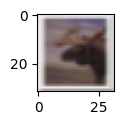

In [17]:
cifar10 = cifar10_preparations(url_10,save_directory,zip_name_10,csv_dataset_10,csv_names_10)
cifar10.dataset_pipeline()
test_convert_and_load(cifar10.csv_dataset_path)

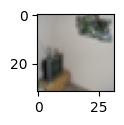

In [18]:
cifar100 = cifar100_preparations(url_100,save_directory,zip_name_100,csv_dataset_100,csv_names_100)
cifar100.dataset_pipeline()
test_convert_and_load(cifar100.csv_dataset_path)

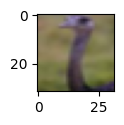

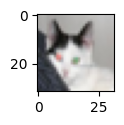

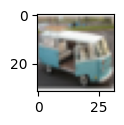

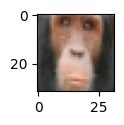

In [19]:
test_convert_and_load(cifar10.csv_dataset_path)
test_convert_and_load(cifar10.csv_dataset_path)
test_convert_and_load(cifar100.csv_dataset_path)
test_convert_and_load(cifar100.csv_dataset_path)

### Add Super Classes From CIFAR-100 To CIFAR-10

In [20]:
class combine_datasets():
    def __init__(self,cifar10,cifar100,our_label_names,csv_combine_dataset,csv_our_label_names):
        self.cifar10=cifar10
        self.cifar100=cifar100
        self.our_label_names=our_label_names
        self.csv_combine_dataset=csv_combine_dataset
        self.csv_our_label_names=csv_our_label_names
#         self.csv_combine_dataset_path
#         self.csv_our_label_names_path 
#         self.df_combine_dataset
        
    def super_class_from_local_CIFAR_100(self,label_name) -> pd.DataFrame:
        # Read labels names
        df_labels_names = pd.read_csv(self.cifar100.csv_names_path)

        # Read CIFAR-100 dataset
        df_cifar_100 = pd.read_csv(self.cifar100.csv_dataset_path)

        label = df_labels_names.index[df_labels_names['coarse_label_names'] == label_name].tolist()[0]
        df = pd.DataFrame(df_cifar_100.loc[df_cifar_100['label'] == label])
        return df
    
    def add_super_classes_from_local_CIFAR_100(self,from_label:int) -> pd.DataFrame:
        # Read CIFAR-10 Labels names
        df_names = pd.read_csv(self.cifar10.csv_names_path)

        dfd = None

        for label_name, label_index in zip(self.our_label_names, range(from_label, from_label + len(self.our_label_names))):
            df = self.super_class_from_local_CIFAR_100(label_name)
            label = df.iloc[0]['label']
            # replace CIFAR-100 label to a proper label 
            df['label'] = df['label'].replace(label, label_index)

            ### store the new labels
            df_new_label_name = pd.DataFrame([label_name], index=[label_index], columns=df_names.columns)
            df_names = pd.concat([df_names, df_new_label_name])
            ##

            # initialize the dataframe or concatenate
            if type(dfd) != pd.core.frame.DataFrame:
                dfd = df
            else:
                dfd = pd.concat([dfd, df])
        ##
        data_folder = os.path.join(self.cifar10.save_directory, 'data')
        self.csv_our_label_names_path = os.path.join(data_folder, self.csv_our_label_names)
        df_names.to_csv(self.csv_our_label_names_path)
        
        # return a single dataframe object of all required labels images from CIFAR-100
        return dfd
    
    def add_super_classes_from_local_CIFAR_100_to_CIFAR_10(self) -> pd.DataFrame:
    
        df_super_classes = self.add_super_classes_from_local_CIFAR_100(10)
        df_cifar_10 = pd.read_csv(self.cifar10.csv_dataset_path)

        # Add what is the origin of data
        df_super_classes["source"] = "cifar-100"
        df_cifar_10["source"] = "cifar-10"

        # concatenate 
        df_dataset = pd.concat([df_cifar_10, df_super_classes])
        # shuffle df
        # df_cifar_10.sample(frac=1)

        # Save the combined dataframe of CIFAR-10 with required labels images of CIFAR-100
        data_folder = os.path.join(self.cifar10.save_directory, 'data')
        self.csv_combine_dataset_path = os.path.join(data_folder, self.csv_combine_dataset)
        df_dataset.to_csv(self.csv_combine_dataset_path)

        self.df_combine_dataset = df_dataset


In [21]:
our_label_names = ['people', 'flowers', 'trees']
csv_combine_dataset = 'combine_dataset.csv'
csv_our_label_names = 'dataset_names.csv'

In [22]:
combine_dataset = combine_datasets(cifar10,cifar100,our_label_names,csv_combine_dataset,csv_our_label_names)

In [23]:
combine_dataset.add_super_classes_from_local_CIFAR_100_to_CIFAR_10()

In [25]:
combine_dataset.df_combine_dataset.head(4)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,label,source
0,59,62,63,43,46,45,50,48,43,68,...,184,140,151,118,84,123,92,72,6,cifar-10
1,154,177,187,126,137,136,105,104,95,102,...,133,139,143,134,142,143,133,144,9,cifar-10
2,255,255,255,253,253,253,253,253,253,253,...,85,83,79,85,83,80,86,84,9,cifar-10
3,28,25,10,37,34,19,38,35,20,42,...,47,28,63,56,37,72,65,46,4,cifar-10


### Analyze Merged Dataset - how many images in each class after the merge of DB

In [26]:
def show_images_ammont_per_class(df_dataset: pd.DataFrame):
    df_dataset['label'].value_counts().plot.bar()

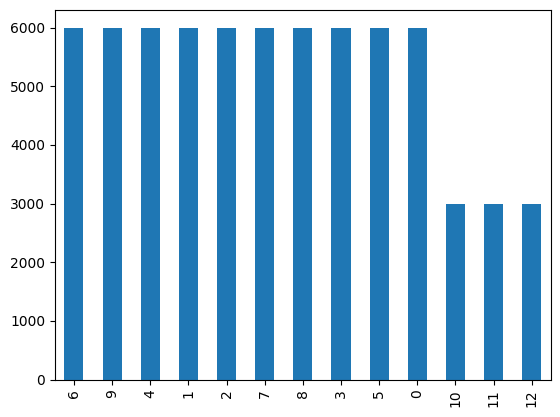

In [27]:
show_images_ammont_per_class(combine_dataset.df_combine_dataset)

### Test Images From CIFAR-100 InCombined Dataset

In [28]:
def test_cifar100_images(df_dataset: pd.DataFrame):
    import random
    ind = random.choice([i for i in range(60000, df_dataset.shape[0])])
    pixels = df_dataset[filter(lambda x: x.startswith('pixel') == True, df_dataset.columns)]
    im = pixels.iloc[ind]
    fig, ax = plt.subplots(figsize=(1,1))
    ax.imshow(np.array(im).reshape(32,32,3))

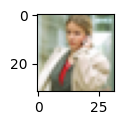

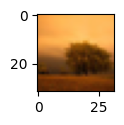

In [31]:
test_cifar100_images(combine_dataset.df_combine_dataset)
test_cifar100_images(combine_dataset.df_combine_dataset)

### Clean the data

In [47]:
def verify_the_data_is_clean(df_dataset: pd.DataFrame):
    print('info: ')
    print(f'{df_dataset.info()}\n')
    print(f'isnull.sum:\n{df_dataset.isnull().sum()}\n')
    print(f'isnull.sum.sum: {df_dataset.isnull().sum().sum()}\n')
    describe = df_dataset.describe()
    print(f'describe:\n{describe}\n')
    print(f'max from the max pixels: {max(describe.loc["max"])}\n')
    print(f'max from the max pixels: {min(describe.loc["min"])}\n')
    unique_label_numbers=df_dataset['label'].unique()
    print(f'uniqe label numbers: {unique_label_numbers}\n')

In [48]:
verify_the_data_is_clean(combine_dataset.df_combine_dataset)

info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69000 entries, 0 to 59984
Columns: 3074 entries, pixel_0 to source
dtypes: int64(3073), object(1)
memory usage: 1.6+ GB
None

isnull.sum:
pixel_0       0
pixel_1       0
pixel_2       0
pixel_3       0
pixel_4       0
             ..
pixel_3069    0
pixel_3070    0
pixel_3071    0
label         0
source        0
Length: 3074, dtype: int64

isnull.sum.sum: 0

describe:
            pixel_0       pixel_1       pixel_2       pixel_3       pixel_4  \
count  69000.000000  69000.000000  69000.000000  69000.000000  69000.000000   
mean     130.577072    136.035580    132.784739    130.135913    135.544203   
std       74.208271     73.623752     81.479101     73.288450     72.685150   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       70.000000     76.000000     59.000000     70.000000     77.000000   
50%      127.000000    135.000000    128.000000    127.000000    135.000000   
75%      190.000000